In [1]:
# Seed value
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
print(tf.__version__) 

tf.random.set_seed(seed_value)     


2.2.0


In [2]:
import os
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

# Load the dataset
dataset = pd.read_csv('st7_train_95_13.csv', header=0, index_col=0)

print('Length of raw data is: ', dataset.shape)
data_org = dataset.iloc[:, :].values

size_train = int(len(data_org) * 0.8)                

data_train = data_org[0 : size_train]
data_valid = data_org[size_train : len(data_org)]

scaler = MinMaxScaler()

train_data = scaler.fit_transform(data_train)
valid_data = scaler.transform(data_valid)


Length of raw data is:  (6575, 7)


In [3]:
from tensorflow import keras
from keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import LSTM, LSTMCell, GRU, GRUCell, Bidirectional

input_dim = data_org.shape[1]                
output_dim = 1
seq_length = 8                               

save_dir = 'st7_checkpoints/'
model_name = 'lstm_1d8.hdf5'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, model_name)

n = 1                                          
def split_data(x_data):
    dataX = []
    dataY = []
    y_data = x_data[:, [-1]]
    for i in range(seq_length, len(y_data) - (n-1)):
        _x = x_data[i - seq_length : i]
        _y = y_data[i + (n-1)] 
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = split_data(train_data)
validX, validY = split_data(valid_data)
print('Length of train data: ', len(trainX))

print('Train data shape: trainX; trainY: ', np.shape(trainX), np.shape(trainY))
print('Valid data shape: validX; validY: ', np.shape(validX), np.shape(validY))

Length of train data:  5252
Train data shape: trainX; trainY:  (5252, 8, 7) (5252, 1)
Valid data shape: validX; validY:  (1307, 8, 7) (1307, 1)


Using TensorFlow backend.


# LSTM and GRU

In [4]:
# Setup Model
num_units = 8                            

model = Sequential()
inputs = (trainX.shape[1], trainX.shape[2])

model.add(LSTM(units=num_units, input_shape=inputs))         
model.add(Dropout(rate=0.2))

model.add(Dense(output_dim))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 512       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
model.compile(loss='mean_squared_error',
              optimizer= keras.optimizers.Adam(0.001),  
              metrics=['accuracy']) 


In [6]:
# EarlyStopping, ModelCheckpoint
min_required = 1e-5       
num_improvement = 2000      
num_period = 10            
num_epochs = 50000

es = EarlyStopping(monitor='val_loss', 
                   min_delta= min_required, 
                   patience=num_improvement, 
                   verbose=1, 
                   mode='auto')

mc = ModelCheckpoint(filepath=save_path, 
                     monitor='val_loss', 
                     verbose=1, save_best_only=True,  
                     mode='auto', 
                     period = num_period)

# Training model
history = model.fit(trainX, trainY,
                    epochs=num_epochs,
                    batch_size = 32,
                    validation_data=(validX, validY),    
                    callbacks=[es, mc],
                    verbose = 2)
            
            
# Evaluate the model
history_dict = history.history
print(history_dict.keys())


Epoch 1/50000
165/165 - 1s - loss: 0.0096 - accuracy: 3.8081e-04 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 2/50000
165/165 - 1s - loss: 0.0042 - accuracy: 3.8081e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 3/50000
165/165 - 1s - loss: 0.0035 - accuracy: 1.9040e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 4/50000
165/165 - 1s - loss: 0.0027 - accuracy: 3.8081e-04 - val_loss: 8.8756e-04 - val_accuracy: 0.0000e+00
Epoch 5/50000
165/165 - 1s - loss: 0.0026 - accuracy: 3.8081e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 6/50000
165/165 - 1s - loss: 0.0021 - accuracy: 3.8081e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 7/50000
165/165 - 1s - loss: 0.0022 - accuracy: 3.8081e-04 - val_loss: 7.5325e-04 - val_accuracy: 0.0000e+00
Epoch 8/50000
165/165 - 1s - loss: 0.0020 - accuracy: 3.8081e-04 - val_loss: 8.6318e-04 - val_accuracy: 0.0000e+00
Epoch 9/50000
165/165 - 1s - loss: 0.0019 - accuracy: 3.8081e-04 - val_loss: 7.4257e-04 - val_accura

Epoch 66/50000
165/165 - 1s - loss: 9.2702e-04 - accuracy: 3.8081e-04 - val_loss: 2.3338e-04 - val_accuracy: 0.0000e+00
Epoch 67/50000
165/165 - 1s - loss: 9.2533e-04 - accuracy: 3.8081e-04 - val_loss: 2.1431e-04 - val_accuracy: 0.0000e+00
Epoch 68/50000
165/165 - 1s - loss: 8.7146e-04 - accuracy: 3.8081e-04 - val_loss: 2.4897e-04 - val_accuracy: 0.0000e+00
Epoch 69/50000
165/165 - 1s - loss: 8.7479e-04 - accuracy: 3.8081e-04 - val_loss: 2.9144e-04 - val_accuracy: 0.0000e+00
Epoch 70/50000

Epoch 00070: val_loss improved from 0.00025 to 0.00024, saving model to st7_checkpoints/lstm_1d8.hdf5
165/165 - 1s - loss: 8.8924e-04 - accuracy: 3.8081e-04 - val_loss: 2.4296e-04 - val_accuracy: 0.0000e+00
Epoch 71/50000
165/165 - 1s - loss: 8.9411e-04 - accuracy: 3.8081e-04 - val_loss: 2.3426e-04 - val_accuracy: 0.0000e+00
Epoch 72/50000
165/165 - 1s - loss: 8.5237e-04 - accuracy: 3.8081e-04 - val_loss: 2.5030e-04 - val_accuracy: 0.0000e+00
Epoch 73/50000
165/165 - 1s - loss: 9.3061e-04 - accuracy

Epoch 131/50000
165/165 - 1s - loss: 8.2594e-04 - accuracy: 3.8081e-04 - val_loss: 2.1887e-04 - val_accuracy: 0.0000e+00
Epoch 132/50000
165/165 - 1s - loss: 8.9346e-04 - accuracy: 3.8081e-04 - val_loss: 2.3456e-04 - val_accuracy: 0.0000e+00
Epoch 133/50000
165/165 - 1s - loss: 7.9834e-04 - accuracy: 3.8081e-04 - val_loss: 2.1483e-04 - val_accuracy: 0.0000e+00
Epoch 134/50000
165/165 - 1s - loss: 8.2705e-04 - accuracy: 3.8081e-04 - val_loss: 1.8408e-04 - val_accuracy: 0.0000e+00
Epoch 135/50000
165/165 - 1s - loss: 8.1877e-04 - accuracy: 3.8081e-04 - val_loss: 2.1563e-04 - val_accuracy: 0.0000e+00
Epoch 136/50000
165/165 - 1s - loss: 8.0319e-04 - accuracy: 3.8081e-04 - val_loss: 2.1129e-04 - val_accuracy: 0.0000e+00
Epoch 137/50000
165/165 - 1s - loss: 8.2725e-04 - accuracy: 3.8081e-04 - val_loss: 2.1770e-04 - val_accuracy: 0.0000e+00
Epoch 138/50000
165/165 - 1s - loss: 8.0706e-04 - accuracy: 3.8081e-04 - val_loss: 2.2779e-04 - val_accuracy: 0.0000e+00
Epoch 139/50000
165/165 - 1s - l

165/165 - 1s - loss: 8.6778e-04 - accuracy: 3.8081e-04 - val_loss: 1.9725e-04 - val_accuracy: 0.0000e+00
Epoch 197/50000
165/165 - 1s - loss: 8.4486e-04 - accuracy: 3.8081e-04 - val_loss: 2.1052e-04 - val_accuracy: 0.0000e+00
Epoch 198/50000
165/165 - 1s - loss: 8.4962e-04 - accuracy: 3.8081e-04 - val_loss: 2.2484e-04 - val_accuracy: 0.0000e+00
Epoch 199/50000
165/165 - 1s - loss: 8.9503e-04 - accuracy: 3.8081e-04 - val_loss: 2.4324e-04 - val_accuracy: 0.0000e+00
Epoch 200/50000

Epoch 00200: val_loss did not improve from 0.00020
165/165 - 1s - loss: 8.1798e-04 - accuracy: 3.8081e-04 - val_loss: 2.2056e-04 - val_accuracy: 0.0000e+00
Epoch 201/50000
165/165 - 1s - loss: 8.5046e-04 - accuracy: 3.8081e-04 - val_loss: 1.7966e-04 - val_accuracy: 0.0000e+00
Epoch 202/50000
165/165 - 1s - loss: 8.2685e-04 - accuracy: 3.8081e-04 - val_loss: 2.1945e-04 - val_accuracy: 0.0000e+00
Epoch 203/50000
165/165 - 1s - loss: 7.9153e-04 - accuracy: 3.8081e-04 - val_loss: 2.3708e-04 - val_accuracy: 0.0000e

Epoch 261/50000
165/165 - 1s - loss: 8.7628e-04 - accuracy: 3.8081e-04 - val_loss: 2.0415e-04 - val_accuracy: 0.0000e+00
Epoch 262/50000
165/165 - 1s - loss: 8.4801e-04 - accuracy: 3.8081e-04 - val_loss: 2.3892e-04 - val_accuracy: 0.0000e+00
Epoch 263/50000
165/165 - 1s - loss: 8.6177e-04 - accuracy: 3.8081e-04 - val_loss: 2.0738e-04 - val_accuracy: 0.0000e+00
Epoch 264/50000
165/165 - 1s - loss: 8.6409e-04 - accuracy: 3.8081e-04 - val_loss: 2.0006e-04 - val_accuracy: 0.0000e+00
Epoch 265/50000
165/165 - 1s - loss: 8.5185e-04 - accuracy: 3.8081e-04 - val_loss: 2.4789e-04 - val_accuracy: 0.0000e+00
Epoch 266/50000
165/165 - 1s - loss: 7.7567e-04 - accuracy: 3.8081e-04 - val_loss: 2.1999e-04 - val_accuracy: 0.0000e+00
Epoch 267/50000
165/165 - 1s - loss: 7.9675e-04 - accuracy: 3.8081e-04 - val_loss: 2.0581e-04 - val_accuracy: 0.0000e+00
Epoch 268/50000
165/165 - 1s - loss: 8.4113e-04 - accuracy: 3.8081e-04 - val_loss: 2.5369e-04 - val_accuracy: 0.0000e+00
Epoch 269/50000
165/165 - 1s - l

165/165 - 1s - loss: 8.0853e-04 - accuracy: 3.8081e-04 - val_loss: 2.1124e-04 - val_accuracy: 0.0000e+00
Epoch 327/50000
165/165 - 1s - loss: 8.1125e-04 - accuracy: 3.8081e-04 - val_loss: 2.5238e-04 - val_accuracy: 0.0000e+00
Epoch 328/50000
165/165 - 1s - loss: 8.0817e-04 - accuracy: 3.8081e-04 - val_loss: 2.3903e-04 - val_accuracy: 0.0000e+00
Epoch 329/50000
165/165 - 1s - loss: 8.3104e-04 - accuracy: 3.8081e-04 - val_loss: 2.3013e-04 - val_accuracy: 0.0000e+00
Epoch 330/50000

Epoch 00330: val_loss did not improve from 0.00017
165/165 - 1s - loss: 8.7348e-04 - accuracy: 3.8081e-04 - val_loss: 1.8271e-04 - val_accuracy: 0.0000e+00
Epoch 331/50000
165/165 - 1s - loss: 7.9219e-04 - accuracy: 3.8081e-04 - val_loss: 2.1184e-04 - val_accuracy: 0.0000e+00
Epoch 332/50000
165/165 - 1s - loss: 8.3889e-04 - accuracy: 3.8081e-04 - val_loss: 2.1054e-04 - val_accuracy: 0.0000e+00
Epoch 333/50000
165/165 - 1s - loss: 7.9018e-04 - accuracy: 3.8081e-04 - val_loss: 1.9160e-04 - val_accuracy: 0.0000e

Epoch 391/50000
165/165 - 1s - loss: 8.3482e-04 - accuracy: 3.8081e-04 - val_loss: 2.4837e-04 - val_accuracy: 0.0000e+00
Epoch 392/50000
165/165 - 1s - loss: 8.0394e-04 - accuracy: 3.8081e-04 - val_loss: 2.1915e-04 - val_accuracy: 0.0000e+00
Epoch 393/50000
165/165 - 1s - loss: 7.9605e-04 - accuracy: 3.8081e-04 - val_loss: 2.0052e-04 - val_accuracy: 0.0000e+00
Epoch 394/50000
165/165 - 1s - loss: 7.6256e-04 - accuracy: 3.8081e-04 - val_loss: 2.0269e-04 - val_accuracy: 0.0000e+00
Epoch 395/50000
165/165 - 1s - loss: 8.1488e-04 - accuracy: 3.8081e-04 - val_loss: 1.7006e-04 - val_accuracy: 0.0000e+00
Epoch 396/50000
165/165 - 1s - loss: 8.3059e-04 - accuracy: 3.8081e-04 - val_loss: 2.2451e-04 - val_accuracy: 0.0000e+00
Epoch 397/50000
165/165 - 1s - loss: 8.0624e-04 - accuracy: 3.8081e-04 - val_loss: 2.4893e-04 - val_accuracy: 0.0000e+00
Epoch 398/50000
165/165 - 1s - loss: 7.7057e-04 - accuracy: 3.8081e-04 - val_loss: 2.2783e-04 - val_accuracy: 0.0000e+00
Epoch 399/50000
165/165 - 1s - l

Epoch 456/50000
165/165 - 1s - loss: 8.8348e-04 - accuracy: 3.8081e-04 - val_loss: 2.2388e-04 - val_accuracy: 0.0000e+00
Epoch 457/50000
165/165 - 1s - loss: 7.9898e-04 - accuracy: 3.8081e-04 - val_loss: 2.1494e-04 - val_accuracy: 0.0000e+00
Epoch 458/50000
165/165 - 1s - loss: 7.6390e-04 - accuracy: 3.8081e-04 - val_loss: 2.5190e-04 - val_accuracy: 0.0000e+00
Epoch 459/50000
165/165 - 1s - loss: 8.6022e-04 - accuracy: 3.8081e-04 - val_loss: 1.7534e-04 - val_accuracy: 0.0000e+00
Epoch 460/50000

Epoch 00460: val_loss did not improve from 0.00017
165/165 - 1s - loss: 8.4112e-04 - accuracy: 3.8081e-04 - val_loss: 1.8540e-04 - val_accuracy: 0.0000e+00
Epoch 461/50000
165/165 - 1s - loss: 8.3011e-04 - accuracy: 3.8081e-04 - val_loss: 2.0669e-04 - val_accuracy: 0.0000e+00
Epoch 462/50000
165/165 - 1s - loss: 7.7360e-04 - accuracy: 3.8081e-04 - val_loss: 2.0145e-04 - val_accuracy: 0.0000e+00
Epoch 463/50000
165/165 - 1s - loss: 8.5237e-04 - accuracy: 3.8081e-04 - val_loss: 1.7010e-04 - val_a

Epoch 521/50000
165/165 - 1s - loss: 8.7471e-04 - accuracy: 3.8081e-04 - val_loss: 2.1376e-04 - val_accuracy: 0.0000e+00
Epoch 522/50000
165/165 - 1s - loss: 7.5261e-04 - accuracy: 3.8081e-04 - val_loss: 2.2926e-04 - val_accuracy: 0.0000e+00
Epoch 523/50000
165/165 - 1s - loss: 7.7289e-04 - accuracy: 3.8081e-04 - val_loss: 1.9887e-04 - val_accuracy: 0.0000e+00
Epoch 524/50000
165/165 - 1s - loss: 7.8326e-04 - accuracy: 3.8081e-04 - val_loss: 1.8198e-04 - val_accuracy: 0.0000e+00
Epoch 525/50000
165/165 - 1s - loss: 8.2184e-04 - accuracy: 3.8081e-04 - val_loss: 1.6593e-04 - val_accuracy: 0.0000e+00
Epoch 526/50000
165/165 - 1s - loss: 7.8081e-04 - accuracy: 3.8081e-04 - val_loss: 2.2159e-04 - val_accuracy: 0.0000e+00
Epoch 527/50000
165/165 - 1s - loss: 8.3539e-04 - accuracy: 3.8081e-04 - val_loss: 2.2500e-04 - val_accuracy: 0.0000e+00
Epoch 528/50000
165/165 - 1s - loss: 8.2705e-04 - accuracy: 3.8081e-04 - val_loss: 2.0328e-04 - val_accuracy: 0.0000e+00
Epoch 529/50000
165/165 - 1s - l

165/165 - 1s - loss: 7.3457e-04 - accuracy: 3.8081e-04 - val_loss: 1.8781e-04 - val_accuracy: 0.0000e+00
Epoch 587/50000
165/165 - 1s - loss: 8.4550e-04 - accuracy: 3.8081e-04 - val_loss: 2.2400e-04 - val_accuracy: 0.0000e+00
Epoch 588/50000
165/165 - 1s - loss: 8.1062e-04 - accuracy: 3.8081e-04 - val_loss: 2.0191e-04 - val_accuracy: 0.0000e+00
Epoch 589/50000
165/165 - 1s - loss: 8.3401e-04 - accuracy: 3.8081e-04 - val_loss: 2.1374e-04 - val_accuracy: 0.0000e+00
Epoch 590/50000

Epoch 00590: val_loss did not improve from 0.00016
165/165 - 1s - loss: 8.3567e-04 - accuracy: 3.8081e-04 - val_loss: 1.8612e-04 - val_accuracy: 0.0000e+00
Epoch 591/50000
165/165 - 1s - loss: 8.3999e-04 - accuracy: 3.8081e-04 - val_loss: 2.2741e-04 - val_accuracy: 0.0000e+00
Epoch 592/50000
165/165 - 1s - loss: 7.4222e-04 - accuracy: 3.8081e-04 - val_loss: 1.9514e-04 - val_accuracy: 0.0000e+00
Epoch 593/50000
165/165 - 1s - loss: 8.2980e-04 - accuracy: 3.8081e-04 - val_loss: 1.8244e-04 - val_accuracy: 0.0000e

Epoch 651/50000
165/165 - 1s - loss: 8.2356e-04 - accuracy: 3.8081e-04 - val_loss: 1.6514e-04 - val_accuracy: 0.0000e+00
Epoch 652/50000
165/165 - 1s - loss: 7.9737e-04 - accuracy: 3.8081e-04 - val_loss: 2.0950e-04 - val_accuracy: 0.0000e+00
Epoch 653/50000
165/165 - 1s - loss: 8.6238e-04 - accuracy: 3.8081e-04 - val_loss: 1.7856e-04 - val_accuracy: 0.0000e+00
Epoch 654/50000
165/165 - 1s - loss: 8.2198e-04 - accuracy: 3.8081e-04 - val_loss: 2.2642e-04 - val_accuracy: 0.0000e+00
Epoch 655/50000
165/165 - 1s - loss: 7.6847e-04 - accuracy: 3.8081e-04 - val_loss: 1.7915e-04 - val_accuracy: 0.0000e+00
Epoch 656/50000
165/165 - 1s - loss: 7.7837e-04 - accuracy: 3.8081e-04 - val_loss: 1.8788e-04 - val_accuracy: 0.0000e+00
Epoch 657/50000
165/165 - 1s - loss: 8.3755e-04 - accuracy: 3.8081e-04 - val_loss: 2.3460e-04 - val_accuracy: 0.0000e+00
Epoch 658/50000
165/165 - 1s - loss: 7.9987e-04 - accuracy: 3.8081e-04 - val_loss: 1.9676e-04 - val_accuracy: 0.0000e+00
Epoch 659/50000
165/165 - 1s - l

Epoch 716/50000
165/165 - 1s - loss: 8.2291e-04 - accuracy: 3.8081e-04 - val_loss: 2.2946e-04 - val_accuracy: 0.0000e+00
Epoch 717/50000
165/165 - 1s - loss: 7.6310e-04 - accuracy: 3.8081e-04 - val_loss: 1.7244e-04 - val_accuracy: 0.0000e+00
Epoch 718/50000
165/165 - 1s - loss: 7.6785e-04 - accuracy: 3.8081e-04 - val_loss: 1.9482e-04 - val_accuracy: 0.0000e+00
Epoch 719/50000
165/165 - 1s - loss: 7.6690e-04 - accuracy: 3.8081e-04 - val_loss: 1.8927e-04 - val_accuracy: 0.0000e+00
Epoch 720/50000

Epoch 00720: val_loss did not improve from 0.00015
165/165 - 1s - loss: 8.6695e-04 - accuracy: 3.8081e-04 - val_loss: 1.8375e-04 - val_accuracy: 0.0000e+00
Epoch 721/50000
165/165 - 1s - loss: 7.6836e-04 - accuracy: 3.8081e-04 - val_loss: 1.8593e-04 - val_accuracy: 0.0000e+00
Epoch 722/50000
165/165 - 1s - loss: 8.5006e-04 - accuracy: 3.8081e-04 - val_loss: 1.7735e-04 - val_accuracy: 0.0000e+00
Epoch 723/50000
165/165 - 1s - loss: 8.6717e-04 - accuracy: 3.8081e-04 - val_loss: 1.9637e-04 - val_a

Epoch 781/50000
165/165 - 1s - loss: 8.2202e-04 - accuracy: 3.8081e-04 - val_loss: 2.4001e-04 - val_accuracy: 0.0000e+00
Epoch 782/50000
165/165 - 1s - loss: 8.7537e-04 - accuracy: 3.8081e-04 - val_loss: 1.7832e-04 - val_accuracy: 0.0000e+00
Epoch 783/50000
165/165 - 1s - loss: 8.1909e-04 - accuracy: 3.8081e-04 - val_loss: 1.9949e-04 - val_accuracy: 0.0000e+00
Epoch 784/50000
165/165 - 1s - loss: 8.1737e-04 - accuracy: 3.8081e-04 - val_loss: 2.2156e-04 - val_accuracy: 0.0000e+00
Epoch 785/50000
165/165 - 1s - loss: 8.4913e-04 - accuracy: 3.8081e-04 - val_loss: 1.8884e-04 - val_accuracy: 0.0000e+00
Epoch 786/50000
165/165 - 1s - loss: 8.3546e-04 - accuracy: 3.8081e-04 - val_loss: 1.8899e-04 - val_accuracy: 0.0000e+00
Epoch 787/50000
165/165 - 1s - loss: 8.0057e-04 - accuracy: 3.8081e-04 - val_loss: 1.9410e-04 - val_accuracy: 0.0000e+00
Epoch 788/50000
165/165 - 1s - loss: 8.7092e-04 - accuracy: 3.8081e-04 - val_loss: 1.5481e-04 - val_accuracy: 0.0000e+00
Epoch 789/50000
165/165 - 1s - l

165/165 - 1s - loss: 7.5973e-04 - accuracy: 3.8081e-04 - val_loss: 2.0015e-04 - val_accuracy: 0.0000e+00
Epoch 847/50000
165/165 - 1s - loss: 7.9917e-04 - accuracy: 3.8081e-04 - val_loss: 2.2502e-04 - val_accuracy: 0.0000e+00
Epoch 848/50000
165/165 - 1s - loss: 7.7579e-04 - accuracy: 3.8081e-04 - val_loss: 1.8546e-04 - val_accuracy: 0.0000e+00
Epoch 849/50000
165/165 - 1s - loss: 8.6350e-04 - accuracy: 3.8081e-04 - val_loss: 1.7035e-04 - val_accuracy: 0.0000e+00
Epoch 850/50000

Epoch 00850: val_loss did not improve from 0.00015
165/165 - 1s - loss: 8.1362e-04 - accuracy: 3.8081e-04 - val_loss: 2.0589e-04 - val_accuracy: 0.0000e+00
Epoch 851/50000
165/165 - 1s - loss: 7.8083e-04 - accuracy: 3.8081e-04 - val_loss: 1.8702e-04 - val_accuracy: 0.0000e+00
Epoch 852/50000
165/165 - 1s - loss: 7.8442e-04 - accuracy: 3.8081e-04 - val_loss: 1.6556e-04 - val_accuracy: 0.0000e+00
Epoch 853/50000
165/165 - 1s - loss: 7.8864e-04 - accuracy: 3.8081e-04 - val_loss: 1.8368e-04 - val_accuracy: 0.0000e

Epoch 911/50000
165/165 - 1s - loss: 8.0181e-04 - accuracy: 3.8081e-04 - val_loss: 1.9789e-04 - val_accuracy: 0.0000e+00
Epoch 912/50000
165/165 - 1s - loss: 7.3120e-04 - accuracy: 3.8081e-04 - val_loss: 1.8902e-04 - val_accuracy: 0.0000e+00
Epoch 913/50000
165/165 - 1s - loss: 7.9584e-04 - accuracy: 3.8081e-04 - val_loss: 2.0493e-04 - val_accuracy: 0.0000e+00
Epoch 914/50000
165/165 - 1s - loss: 8.2540e-04 - accuracy: 3.8081e-04 - val_loss: 2.0776e-04 - val_accuracy: 0.0000e+00
Epoch 915/50000
165/165 - 1s - loss: 7.9247e-04 - accuracy: 3.8081e-04 - val_loss: 1.8118e-04 - val_accuracy: 0.0000e+00
Epoch 916/50000
165/165 - 1s - loss: 8.2023e-04 - accuracy: 3.8081e-04 - val_loss: 1.7749e-04 - val_accuracy: 0.0000e+00
Epoch 917/50000
165/165 - 1s - loss: 8.2476e-04 - accuracy: 3.8081e-04 - val_loss: 2.4840e-04 - val_accuracy: 0.0000e+00
Epoch 918/50000
165/165 - 1s - loss: 8.4033e-04 - accuracy: 3.8081e-04 - val_loss: 2.3352e-04 - val_accuracy: 0.0000e+00
Epoch 919/50000
165/165 - 1s - l

165/165 - 1s - loss: 7.1755e-04 - accuracy: 3.8081e-04 - val_loss: 2.0394e-04 - val_accuracy: 0.0000e+00
Epoch 977/50000
165/165 - 1s - loss: 8.3004e-04 - accuracy: 3.8081e-04 - val_loss: 1.6694e-04 - val_accuracy: 0.0000e+00
Epoch 978/50000
165/165 - 1s - loss: 7.9695e-04 - accuracy: 3.8081e-04 - val_loss: 2.3550e-04 - val_accuracy: 0.0000e+00
Epoch 979/50000
165/165 - 1s - loss: 8.4354e-04 - accuracy: 3.8081e-04 - val_loss: 2.2591e-04 - val_accuracy: 0.0000e+00
Epoch 980/50000

Epoch 00980: val_loss did not improve from 0.00015
165/165 - 1s - loss: 7.7018e-04 - accuracy: 3.8081e-04 - val_loss: 1.8796e-04 - val_accuracy: 0.0000e+00
Epoch 981/50000
165/165 - 1s - loss: 7.8532e-04 - accuracy: 3.8081e-04 - val_loss: 1.7723e-04 - val_accuracy: 0.0000e+00
Epoch 982/50000
165/165 - 1s - loss: 7.2847e-04 - accuracy: 3.8081e-04 - val_loss: 2.0160e-04 - val_accuracy: 0.0000e+00
Epoch 983/50000
165/165 - 1s - loss: 8.2119e-04 - accuracy: 3.8081e-04 - val_loss: 1.8891e-04 - val_accuracy: 0.0000e

Epoch 1041/50000
165/165 - 1s - loss: 8.0058e-04 - accuracy: 3.8081e-04 - val_loss: 2.0858e-04 - val_accuracy: 0.0000e+00
Epoch 1042/50000
165/165 - 1s - loss: 8.4025e-04 - accuracy: 3.8081e-04 - val_loss: 1.7396e-04 - val_accuracy: 0.0000e+00
Epoch 1043/50000
165/165 - 1s - loss: 8.1963e-04 - accuracy: 3.8081e-04 - val_loss: 1.7727e-04 - val_accuracy: 0.0000e+00
Epoch 1044/50000
165/165 - 1s - loss: 7.9655e-04 - accuracy: 3.8081e-04 - val_loss: 1.8681e-04 - val_accuracy: 0.0000e+00
Epoch 1045/50000
165/165 - 1s - loss: 8.1056e-04 - accuracy: 3.8081e-04 - val_loss: 1.6941e-04 - val_accuracy: 0.0000e+00
Epoch 1046/50000
165/165 - 1s - loss: 8.3608e-04 - accuracy: 3.8081e-04 - val_loss: 2.1421e-04 - val_accuracy: 0.0000e+00
Epoch 1047/50000
165/165 - 1s - loss: 8.1708e-04 - accuracy: 3.8081e-04 - val_loss: 1.9431e-04 - val_accuracy: 0.0000e+00
Epoch 1048/50000
165/165 - 1s - loss: 7.3158e-04 - accuracy: 3.8081e-04 - val_loss: 2.0373e-04 - val_accuracy: 0.0000e+00
Epoch 1049/50000
165/165

Epoch 1106/50000
165/165 - 1s - loss: 8.1005e-04 - accuracy: 3.8081e-04 - val_loss: 1.6622e-04 - val_accuracy: 0.0000e+00
Epoch 1107/50000
165/165 - 1s - loss: 8.0685e-04 - accuracy: 3.8081e-04 - val_loss: 1.7352e-04 - val_accuracy: 0.0000e+00
Epoch 1108/50000
165/165 - 1s - loss: 7.8715e-04 - accuracy: 3.8081e-04 - val_loss: 2.0436e-04 - val_accuracy: 0.0000e+00
Epoch 1109/50000
165/165 - 1s - loss: 8.4995e-04 - accuracy: 3.8081e-04 - val_loss: 1.9590e-04 - val_accuracy: 0.0000e+00
Epoch 1110/50000

Epoch 01110: val_loss did not improve from 0.00015
165/165 - 1s - loss: 7.4651e-04 - accuracy: 3.8081e-04 - val_loss: 1.7206e-04 - val_accuracy: 0.0000e+00
Epoch 1111/50000
165/165 - 1s - loss: 8.2381e-04 - accuracy: 3.8081e-04 - val_loss: 1.6577e-04 - val_accuracy: 0.0000e+00
Epoch 1112/50000
165/165 - 1s - loss: 8.2730e-04 - accuracy: 3.8081e-04 - val_loss: 2.0767e-04 - val_accuracy: 0.0000e+00
Epoch 1113/50000
165/165 - 1s - loss: 8.4959e-04 - accuracy: 3.8081e-04 - val_loss: 1.6873e-04

Epoch 1171/50000
165/165 - 1s - loss: 8.2730e-04 - accuracy: 3.8081e-04 - val_loss: 1.8725e-04 - val_accuracy: 0.0000e+00
Epoch 1172/50000
165/165 - 1s - loss: 7.0352e-04 - accuracy: 3.8081e-04 - val_loss: 1.8370e-04 - val_accuracy: 0.0000e+00
Epoch 1173/50000
165/165 - 1s - loss: 8.0011e-04 - accuracy: 3.8081e-04 - val_loss: 1.8355e-04 - val_accuracy: 0.0000e+00
Epoch 1174/50000
165/165 - 1s - loss: 7.9039e-04 - accuracy: 3.8081e-04 - val_loss: 1.7534e-04 - val_accuracy: 0.0000e+00
Epoch 1175/50000
165/165 - 1s - loss: 8.8492e-04 - accuracy: 3.8081e-04 - val_loss: 1.6564e-04 - val_accuracy: 0.0000e+00
Epoch 1176/50000
165/165 - 1s - loss: 8.2057e-04 - accuracy: 3.8081e-04 - val_loss: 1.6866e-04 - val_accuracy: 0.0000e+00
Epoch 1177/50000
165/165 - 1s - loss: 8.4648e-04 - accuracy: 3.8081e-04 - val_loss: 2.0516e-04 - val_accuracy: 0.0000e+00
Epoch 1178/50000
165/165 - 1s - loss: 7.7960e-04 - accuracy: 3.8081e-04 - val_loss: 1.6369e-04 - val_accuracy: 0.0000e+00
Epoch 1179/50000
165/165

Epoch 1236/50000
165/165 - 1s - loss: 7.7137e-04 - accuracy: 3.8081e-04 - val_loss: 1.8365e-04 - val_accuracy: 0.0000e+00
Epoch 1237/50000
165/165 - 1s - loss: 8.2569e-04 - accuracy: 3.8081e-04 - val_loss: 2.3431e-04 - val_accuracy: 0.0000e+00
Epoch 1238/50000
165/165 - 1s - loss: 8.4020e-04 - accuracy: 3.8081e-04 - val_loss: 2.0561e-04 - val_accuracy: 0.0000e+00
Epoch 1239/50000
165/165 - 1s - loss: 7.3507e-04 - accuracy: 3.8081e-04 - val_loss: 1.9902e-04 - val_accuracy: 0.0000e+00
Epoch 1240/50000

Epoch 01240: val_loss did not improve from 0.00015
165/165 - 1s - loss: 8.1821e-04 - accuracy: 3.8081e-04 - val_loss: 2.1948e-04 - val_accuracy: 0.0000e+00
Epoch 1241/50000
165/165 - 1s - loss: 8.5944e-04 - accuracy: 3.8081e-04 - val_loss: 2.1477e-04 - val_accuracy: 0.0000e+00
Epoch 1242/50000
165/165 - 1s - loss: 8.1545e-04 - accuracy: 3.8081e-04 - val_loss: 1.9367e-04 - val_accuracy: 0.0000e+00
Epoch 1243/50000
165/165 - 1s - loss: 7.5782e-04 - accuracy: 3.8081e-04 - val_loss: 1.9170e-04

Epoch 1301/50000
165/165 - 1s - loss: 8.9954e-04 - accuracy: 3.8081e-04 - val_loss: 1.9982e-04 - val_accuracy: 0.0000e+00
Epoch 1302/50000
165/165 - 1s - loss: 8.1406e-04 - accuracy: 3.8081e-04 - val_loss: 2.3141e-04 - val_accuracy: 0.0000e+00
Epoch 1303/50000
165/165 - 1s - loss: 8.1943e-04 - accuracy: 3.8081e-04 - val_loss: 1.6601e-04 - val_accuracy: 0.0000e+00
Epoch 1304/50000
165/165 - 1s - loss: 8.1387e-04 - accuracy: 3.8081e-04 - val_loss: 2.3581e-04 - val_accuracy: 0.0000e+00
Epoch 1305/50000
165/165 - 1s - loss: 8.1116e-04 - accuracy: 3.8081e-04 - val_loss: 1.8055e-04 - val_accuracy: 0.0000e+00
Epoch 1306/50000
165/165 - 1s - loss: 7.6898e-04 - accuracy: 3.8081e-04 - val_loss: 2.2756e-04 - val_accuracy: 0.0000e+00
Epoch 1307/50000
165/165 - 1s - loss: 7.4975e-04 - accuracy: 3.8081e-04 - val_loss: 1.7376e-04 - val_accuracy: 0.0000e+00
Epoch 1308/50000
165/165 - 1s - loss: 8.0670e-04 - accuracy: 3.8081e-04 - val_loss: 1.6428e-04 - val_accuracy: 0.0000e+00
Epoch 1309/50000
165/165

Epoch 1366/50000
165/165 - 1s - loss: 7.2165e-04 - accuracy: 3.8081e-04 - val_loss: 1.8527e-04 - val_accuracy: 0.0000e+00
Epoch 1367/50000
165/165 - 1s - loss: 7.5073e-04 - accuracy: 3.8081e-04 - val_loss: 2.0039e-04 - val_accuracy: 0.0000e+00
Epoch 1368/50000
165/165 - 1s - loss: 8.3956e-04 - accuracy: 3.8081e-04 - val_loss: 1.7582e-04 - val_accuracy: 0.0000e+00
Epoch 1369/50000
165/165 - 1s - loss: 8.4122e-04 - accuracy: 3.8081e-04 - val_loss: 1.5716e-04 - val_accuracy: 0.0000e+00
Epoch 1370/50000

Epoch 01370: val_loss did not improve from 0.00015
165/165 - 1s - loss: 8.8824e-04 - accuracy: 3.8081e-04 - val_loss: 1.8333e-04 - val_accuracy: 0.0000e+00
Epoch 1371/50000
165/165 - 1s - loss: 7.8543e-04 - accuracy: 3.8081e-04 - val_loss: 2.0294e-04 - val_accuracy: 0.0000e+00
Epoch 1372/50000
165/165 - 1s - loss: 7.8144e-04 - accuracy: 3.8081e-04 - val_loss: 1.7824e-04 - val_accuracy: 0.0000e+00
Epoch 1373/50000
165/165 - 1s - loss: 8.2978e-04 - accuracy: 3.8081e-04 - val_loss: 1.7071e-04

Epoch 1431/50000
165/165 - 1s - loss: 8.1785e-04 - accuracy: 3.8081e-04 - val_loss: 1.7025e-04 - val_accuracy: 0.0000e+00
Epoch 1432/50000
165/165 - 1s - loss: 7.8240e-04 - accuracy: 3.8081e-04 - val_loss: 2.2029e-04 - val_accuracy: 0.0000e+00
Epoch 1433/50000
165/165 - 1s - loss: 8.5844e-04 - accuracy: 3.8081e-04 - val_loss: 1.8549e-04 - val_accuracy: 0.0000e+00
Epoch 1434/50000
165/165 - 1s - loss: 8.2249e-04 - accuracy: 3.8081e-04 - val_loss: 2.2893e-04 - val_accuracy: 0.0000e+00
Epoch 1435/50000
165/165 - 1s - loss: 8.2376e-04 - accuracy: 3.8081e-04 - val_loss: 2.0783e-04 - val_accuracy: 0.0000e+00
Epoch 1436/50000
165/165 - 1s - loss: 7.9228e-04 - accuracy: 3.8081e-04 - val_loss: 1.7560e-04 - val_accuracy: 0.0000e+00
Epoch 1437/50000
165/165 - 1s - loss: 7.5158e-04 - accuracy: 3.8081e-04 - val_loss: 2.4630e-04 - val_accuracy: 0.0000e+00
Epoch 1438/50000
165/165 - 1s - loss: 7.5106e-04 - accuracy: 3.8081e-04 - val_loss: 1.7033e-04 - val_accuracy: 0.0000e+00
Epoch 1439/50000
165/165

Epoch 1496/50000
165/165 - 1s - loss: 8.0263e-04 - accuracy: 3.8081e-04 - val_loss: 2.0201e-04 - val_accuracy: 0.0000e+00
Epoch 1497/50000
165/165 - 1s - loss: 7.4316e-04 - accuracy: 3.8081e-04 - val_loss: 1.7854e-04 - val_accuracy: 0.0000e+00
Epoch 1498/50000
165/165 - 1s - loss: 7.1865e-04 - accuracy: 3.8081e-04 - val_loss: 1.6285e-04 - val_accuracy: 0.0000e+00
Epoch 1499/50000
165/165 - 1s - loss: 8.2448e-04 - accuracy: 3.8081e-04 - val_loss: 1.8944e-04 - val_accuracy: 0.0000e+00
Epoch 1500/50000

Epoch 01500: val_loss did not improve from 0.00015
165/165 - 1s - loss: 7.4971e-04 - accuracy: 3.8081e-04 - val_loss: 2.0268e-04 - val_accuracy: 0.0000e+00
Epoch 1501/50000
165/165 - 1s - loss: 8.4502e-04 - accuracy: 3.8081e-04 - val_loss: 2.2522e-04 - val_accuracy: 0.0000e+00
Epoch 1502/50000
165/165 - 1s - loss: 7.9884e-04 - accuracy: 3.8081e-04 - val_loss: 1.6498e-04 - val_accuracy: 0.0000e+00
Epoch 1503/50000
165/165 - 1s - loss: 8.6172e-04 - accuracy: 3.8081e-04 - val_loss: 1.9820e-04

Epoch 1561/50000
165/165 - 1s - loss: 7.6647e-04 - accuracy: 3.8081e-04 - val_loss: 1.6803e-04 - val_accuracy: 0.0000e+00
Epoch 1562/50000
165/165 - 1s - loss: 8.5213e-04 - accuracy: 3.8081e-04 - val_loss: 1.8816e-04 - val_accuracy: 0.0000e+00
Epoch 1563/50000
165/165 - 1s - loss: 7.4992e-04 - accuracy: 3.8081e-04 - val_loss: 1.7129e-04 - val_accuracy: 0.0000e+00
Epoch 1564/50000
165/165 - 1s - loss: 7.5868e-04 - accuracy: 3.8081e-04 - val_loss: 1.9751e-04 - val_accuracy: 0.0000e+00
Epoch 1565/50000
165/165 - 1s - loss: 7.9064e-04 - accuracy: 3.8081e-04 - val_loss: 1.6768e-04 - val_accuracy: 0.0000e+00
Epoch 1566/50000
165/165 - 1s - loss: 7.9172e-04 - accuracy: 3.8081e-04 - val_loss: 1.4959e-04 - val_accuracy: 0.0000e+00
Epoch 1567/50000
165/165 - 1s - loss: 8.5741e-04 - accuracy: 3.8081e-04 - val_loss: 1.9070e-04 - val_accuracy: 0.0000e+00
Epoch 1568/50000
165/165 - 1s - loss: 8.0630e-04 - accuracy: 3.8081e-04 - val_loss: 2.1911e-04 - val_accuracy: 0.0000e+00
Epoch 1569/50000
165/165

Epoch 1626/50000
165/165 - 1s - loss: 7.6547e-04 - accuracy: 3.8081e-04 - val_loss: 1.9443e-04 - val_accuracy: 0.0000e+00
Epoch 1627/50000
165/165 - 1s - loss: 9.0778e-04 - accuracy: 3.8081e-04 - val_loss: 1.6574e-04 - val_accuracy: 0.0000e+00
Epoch 1628/50000
165/165 - 1s - loss: 8.2424e-04 - accuracy: 3.8081e-04 - val_loss: 1.8831e-04 - val_accuracy: 0.0000e+00
Epoch 1629/50000
165/165 - 1s - loss: 7.6146e-04 - accuracy: 3.8081e-04 - val_loss: 1.7520e-04 - val_accuracy: 0.0000e+00
Epoch 1630/50000

Epoch 01630: val_loss did not improve from 0.00015
165/165 - 1s - loss: 7.9533e-04 - accuracy: 3.8081e-04 - val_loss: 2.2031e-04 - val_accuracy: 0.0000e+00
Epoch 1631/50000
165/165 - 1s - loss: 8.3110e-04 - accuracy: 3.8081e-04 - val_loss: 1.8763e-04 - val_accuracy: 0.0000e+00
Epoch 1632/50000
165/165 - 1s - loss: 8.1800e-04 - accuracy: 3.8081e-04 - val_loss: 1.9665e-04 - val_accuracy: 0.0000e+00
Epoch 1633/50000
165/165 - 1s - loss: 7.6315e-04 - accuracy: 3.8081e-04 - val_loss: 2.0384e-04

Epoch 1691/50000
165/165 - 1s - loss: 7.6908e-04 - accuracy: 3.8081e-04 - val_loss: 2.0330e-04 - val_accuracy: 0.0000e+00
Epoch 1692/50000
165/165 - 1s - loss: 8.5076e-04 - accuracy: 3.8081e-04 - val_loss: 1.7987e-04 - val_accuracy: 0.0000e+00
Epoch 1693/50000
165/165 - 1s - loss: 8.6950e-04 - accuracy: 3.8081e-04 - val_loss: 1.6449e-04 - val_accuracy: 0.0000e+00
Epoch 1694/50000
165/165 - 1s - loss: 8.0160e-04 - accuracy: 3.8081e-04 - val_loss: 2.0014e-04 - val_accuracy: 0.0000e+00
Epoch 1695/50000
165/165 - 1s - loss: 7.7382e-04 - accuracy: 3.8081e-04 - val_loss: 1.8993e-04 - val_accuracy: 0.0000e+00
Epoch 1696/50000
165/165 - 1s - loss: 8.3031e-04 - accuracy: 3.8081e-04 - val_loss: 2.0663e-04 - val_accuracy: 0.0000e+00
Epoch 1697/50000
165/165 - 1s - loss: 7.5018e-04 - accuracy: 3.8081e-04 - val_loss: 2.0136e-04 - val_accuracy: 0.0000e+00
Epoch 1698/50000
165/165 - 1s - loss: 8.3915e-04 - accuracy: 3.8081e-04 - val_loss: 1.9836e-04 - val_accuracy: 0.0000e+00
Epoch 1699/50000
165/165

Epoch 1756/50000
165/165 - 1s - loss: 8.5613e-04 - accuracy: 3.8081e-04 - val_loss: 1.6831e-04 - val_accuracy: 0.0000e+00
Epoch 1757/50000
165/165 - 1s - loss: 7.6996e-04 - accuracy: 3.8081e-04 - val_loss: 1.6610e-04 - val_accuracy: 0.0000e+00
Epoch 1758/50000
165/165 - 1s - loss: 8.7553e-04 - accuracy: 3.8081e-04 - val_loss: 1.9722e-04 - val_accuracy: 0.0000e+00
Epoch 1759/50000
165/165 - 1s - loss: 7.6686e-04 - accuracy: 3.8081e-04 - val_loss: 1.7490e-04 - val_accuracy: 0.0000e+00
Epoch 1760/50000

Epoch 01760: val_loss did not improve from 0.00015
165/165 - 1s - loss: 7.3378e-04 - accuracy: 3.8081e-04 - val_loss: 1.9348e-04 - val_accuracy: 0.0000e+00
Epoch 1761/50000
165/165 - 1s - loss: 7.7978e-04 - accuracy: 3.8081e-04 - val_loss: 2.0133e-04 - val_accuracy: 0.0000e+00
Epoch 1762/50000
165/165 - 1s - loss: 7.6378e-04 - accuracy: 3.8081e-04 - val_loss: 2.0684e-04 - val_accuracy: 0.0000e+00
Epoch 1763/50000
165/165 - 1s - loss: 7.7120e-04 - accuracy: 3.8081e-04 - val_loss: 1.8874e-04

Epoch 1821/50000
165/165 - 1s - loss: 7.9409e-04 - accuracy: 3.8081e-04 - val_loss: 1.7736e-04 - val_accuracy: 0.0000e+00
Epoch 1822/50000
165/165 - 1s - loss: 8.4954e-04 - accuracy: 3.8081e-04 - val_loss: 1.6869e-04 - val_accuracy: 0.0000e+00
Epoch 1823/50000
165/165 - 1s - loss: 8.5181e-04 - accuracy: 3.8081e-04 - val_loss: 1.4905e-04 - val_accuracy: 0.0000e+00
Epoch 1824/50000
165/165 - 1s - loss: 7.7000e-04 - accuracy: 3.8081e-04 - val_loss: 1.7205e-04 - val_accuracy: 0.0000e+00
Epoch 1825/50000
165/165 - 1s - loss: 8.0608e-04 - accuracy: 3.8081e-04 - val_loss: 1.6962e-04 - val_accuracy: 0.0000e+00
Epoch 1826/50000
165/165 - 1s - loss: 8.1466e-04 - accuracy: 3.8081e-04 - val_loss: 1.9692e-04 - val_accuracy: 0.0000e+00
Epoch 1827/50000
165/165 - 1s - loss: 7.7621e-04 - accuracy: 3.8081e-04 - val_loss: 1.9831e-04 - val_accuracy: 0.0000e+00
Epoch 1828/50000
165/165 - 1s - loss: 8.5848e-04 - accuracy: 3.8081e-04 - val_loss: 1.9686e-04 - val_accuracy: 0.0000e+00
Epoch 1829/50000
165/165

Epoch 1886/50000
165/165 - 1s - loss: 7.8965e-04 - accuracy: 3.8081e-04 - val_loss: 1.6400e-04 - val_accuracy: 0.0000e+00
Epoch 1887/50000
165/165 - 1s - loss: 7.7964e-04 - accuracy: 3.8081e-04 - val_loss: 1.7603e-04 - val_accuracy: 0.0000e+00
Epoch 1888/50000
165/165 - 1s - loss: 7.6628e-04 - accuracy: 3.8081e-04 - val_loss: 2.3859e-04 - val_accuracy: 0.0000e+00
Epoch 1889/50000
165/165 - 1s - loss: 7.7799e-04 - accuracy: 3.8081e-04 - val_loss: 1.7237e-04 - val_accuracy: 0.0000e+00
Epoch 1890/50000

Epoch 01890: val_loss did not improve from 0.00015
165/165 - 1s - loss: 8.2460e-04 - accuracy: 3.8081e-04 - val_loss: 1.7235e-04 - val_accuracy: 0.0000e+00
Epoch 1891/50000
165/165 - 1s - loss: 7.8037e-04 - accuracy: 3.8081e-04 - val_loss: 2.1786e-04 - val_accuracy: 0.0000e+00
Epoch 1892/50000
165/165 - 1s - loss: 7.7905e-04 - accuracy: 3.8081e-04 - val_loss: 2.3720e-04 - val_accuracy: 0.0000e+00
Epoch 1893/50000
165/165 - 1s - loss: 8.2722e-04 - accuracy: 3.8081e-04 - val_loss: 2.2565e-04

Epoch 1951/50000
165/165 - 1s - loss: 8.3132e-04 - accuracy: 3.8081e-04 - val_loss: 1.6916e-04 - val_accuracy: 0.0000e+00
Epoch 1952/50000
165/165 - 1s - loss: 7.9047e-04 - accuracy: 3.8081e-04 - val_loss: 1.7604e-04 - val_accuracy: 0.0000e+00
Epoch 1953/50000
165/165 - 1s - loss: 7.5347e-04 - accuracy: 3.8081e-04 - val_loss: 2.0697e-04 - val_accuracy: 0.0000e+00
Epoch 1954/50000
165/165 - 1s - loss: 7.4321e-04 - accuracy: 3.8081e-04 - val_loss: 1.8362e-04 - val_accuracy: 0.0000e+00
Epoch 1955/50000
165/165 - 1s - loss: 8.5091e-04 - accuracy: 3.8081e-04 - val_loss: 1.9288e-04 - val_accuracy: 0.0000e+00
Epoch 1956/50000
165/165 - 1s - loss: 7.6509e-04 - accuracy: 3.8081e-04 - val_loss: 1.6309e-04 - val_accuracy: 0.0000e+00
Epoch 1957/50000
165/165 - 1s - loss: 7.5478e-04 - accuracy: 3.8081e-04 - val_loss: 1.8507e-04 - val_accuracy: 0.0000e+00
Epoch 1958/50000
165/165 - 1s - loss: 7.7981e-04 - accuracy: 3.8081e-04 - val_loss: 2.3571e-04 - val_accuracy: 0.0000e+00
Epoch 1959/50000
165/165

Epoch 2016/50000
165/165 - 1s - loss: 8.4336e-04 - accuracy: 3.8081e-04 - val_loss: 1.6371e-04 - val_accuracy: 0.0000e+00
Epoch 2017/50000
165/165 - 1s - loss: 8.8659e-04 - accuracy: 3.8081e-04 - val_loss: 2.0192e-04 - val_accuracy: 0.0000e+00
Epoch 2018/50000
165/165 - 1s - loss: 8.1139e-04 - accuracy: 3.8081e-04 - val_loss: 1.9721e-04 - val_accuracy: 0.0000e+00
Epoch 2019/50000
165/165 - 1s - loss: 7.7077e-04 - accuracy: 3.8081e-04 - val_loss: 1.9682e-04 - val_accuracy: 0.0000e+00
Epoch 2020/50000

Epoch 02020: val_loss did not improve from 0.00015
165/165 - 1s - loss: 8.1497e-04 - accuracy: 3.8081e-04 - val_loss: 2.1284e-04 - val_accuracy: 0.0000e+00
Epoch 2021/50000
165/165 - 1s - loss: 7.1861e-04 - accuracy: 3.8081e-04 - val_loss: 1.5093e-04 - val_accuracy: 0.0000e+00
Epoch 2022/50000
165/165 - 1s - loss: 8.3358e-04 - accuracy: 3.8081e-04 - val_loss: 1.8132e-04 - val_accuracy: 0.0000e+00
Epoch 2023/50000
165/165 - 1s - loss: 7.7509e-04 - accuracy: 3.8081e-04 - val_loss: 2.0424e-04

Epoch 2081/50000
165/165 - 1s - loss: 8.2100e-04 - accuracy: 3.8081e-04 - val_loss: 2.0977e-04 - val_accuracy: 0.0000e+00
Epoch 2082/50000
165/165 - 1s - loss: 7.9542e-04 - accuracy: 3.8081e-04 - val_loss: 2.1165e-04 - val_accuracy: 0.0000e+00
Epoch 2083/50000
165/165 - 1s - loss: 8.5809e-04 - accuracy: 3.8081e-04 - val_loss: 1.6846e-04 - val_accuracy: 0.0000e+00
Epoch 2084/50000
165/165 - 1s - loss: 7.9104e-04 - accuracy: 3.8081e-04 - val_loss: 1.9838e-04 - val_accuracy: 0.0000e+00
Epoch 2085/50000
165/165 - 1s - loss: 8.5293e-04 - accuracy: 3.8081e-04 - val_loss: 2.0429e-04 - val_accuracy: 0.0000e+00
Epoch 2086/50000
165/165 - 1s - loss: 7.6645e-04 - accuracy: 3.8081e-04 - val_loss: 1.5328e-04 - val_accuracy: 0.0000e+00
Epoch 2087/50000
165/165 - 1s - loss: 8.0617e-04 - accuracy: 3.8081e-04 - val_loss: 1.9878e-04 - val_accuracy: 0.0000e+00
Epoch 2088/50000
165/165 - 1s - loss: 7.9998e-04 - accuracy: 3.8081e-04 - val_loss: 1.7936e-04 - val_accuracy: 0.0000e+00
Epoch 2089/50000
165/165

Epoch 2146/50000
165/165 - 1s - loss: 7.7573e-04 - accuracy: 3.8081e-04 - val_loss: 1.8201e-04 - val_accuracy: 0.0000e+00
Epoch 2147/50000
165/165 - 1s - loss: 7.0349e-04 - accuracy: 3.8081e-04 - val_loss: 1.7672e-04 - val_accuracy: 0.0000e+00
Epoch 2148/50000
165/165 - 1s - loss: 8.7130e-04 - accuracy: 3.8081e-04 - val_loss: 1.8301e-04 - val_accuracy: 0.0000e+00
Epoch 2149/50000
165/165 - 1s - loss: 7.4597e-04 - accuracy: 3.8081e-04 - val_loss: 2.0500e-04 - val_accuracy: 0.0000e+00
Epoch 2150/50000

Epoch 02150: val_loss did not improve from 0.00015
165/165 - 1s - loss: 8.1306e-04 - accuracy: 3.8081e-04 - val_loss: 1.6736e-04 - val_accuracy: 0.0000e+00
Epoch 2151/50000
165/165 - 1s - loss: 7.7259e-04 - accuracy: 3.8081e-04 - val_loss: 1.9370e-04 - val_accuracy: 0.0000e+00
Epoch 2152/50000
165/165 - 1s - loss: 7.5854e-04 - accuracy: 3.8081e-04 - val_loss: 1.7936e-04 - val_accuracy: 0.0000e+00
Epoch 2153/50000
165/165 - 1s - loss: 7.6801e-04 - accuracy: 3.8081e-04 - val_loss: 2.0761e-04

Epoch 2211/50000
165/165 - 1s - loss: 8.2608e-04 - accuracy: 3.8081e-04 - val_loss: 1.8692e-04 - val_accuracy: 0.0000e+00
Epoch 2212/50000
165/165 - 1s - loss: 8.6031e-04 - accuracy: 3.8081e-04 - val_loss: 1.5751e-04 - val_accuracy: 0.0000e+00
Epoch 2213/50000
165/165 - 1s - loss: 8.4565e-04 - accuracy: 3.8081e-04 - val_loss: 2.0338e-04 - val_accuracy: 0.0000e+00
Epoch 2214/50000
165/165 - 1s - loss: 8.6341e-04 - accuracy: 3.8081e-04 - val_loss: 2.1557e-04 - val_accuracy: 0.0000e+00
Epoch 2215/50000
165/165 - 1s - loss: 8.0806e-04 - accuracy: 3.8081e-04 - val_loss: 1.8962e-04 - val_accuracy: 0.0000e+00
Epoch 2216/50000
165/165 - 1s - loss: 7.9875e-04 - accuracy: 3.8081e-04 - val_loss: 1.5967e-04 - val_accuracy: 0.0000e+00
Epoch 2217/50000
165/165 - 1s - loss: 7.4618e-04 - accuracy: 3.8081e-04 - val_loss: 2.0122e-04 - val_accuracy: 0.0000e+00
Epoch 2218/50000
165/165 - 1s - loss: 7.1967e-04 - accuracy: 3.8081e-04 - val_loss: 1.8990e-04 - val_accuracy: 0.0000e+00
Epoch 2219/50000
165/165

Epoch 2276/50000
165/165 - 1s - loss: 7.4412e-04 - accuracy: 3.8081e-04 - val_loss: 2.3037e-04 - val_accuracy: 0.0000e+00
Epoch 2277/50000
165/165 - 1s - loss: 7.8296e-04 - accuracy: 3.8081e-04 - val_loss: 1.8614e-04 - val_accuracy: 0.0000e+00
Epoch 2278/50000
165/165 - 1s - loss: 7.5551e-04 - accuracy: 3.8081e-04 - val_loss: 1.9597e-04 - val_accuracy: 0.0000e+00
Epoch 2279/50000
165/165 - 1s - loss: 7.3036e-04 - accuracy: 3.8081e-04 - val_loss: 1.6662e-04 - val_accuracy: 0.0000e+00
Epoch 2280/50000

Epoch 02280: val_loss did not improve from 0.00015
165/165 - 1s - loss: 8.5191e-04 - accuracy: 3.8081e-04 - val_loss: 2.0389e-04 - val_accuracy: 0.0000e+00
Epoch 2281/50000
165/165 - 1s - loss: 8.1130e-04 - accuracy: 1.9040e-04 - val_loss: 1.8221e-04 - val_accuracy: 0.0000e+00
Epoch 2282/50000
165/165 - 1s - loss: 7.7879e-04 - accuracy: 3.8081e-04 - val_loss: 1.9850e-04 - val_accuracy: 0.0000e+00
Epoch 2283/50000
165/165 - 1s - loss: 7.5310e-04 - accuracy: 3.8081e-04 - val_loss: 1.9804e-04

Epoch 2341/50000
165/165 - 1s - loss: 8.0089e-04 - accuracy: 3.8081e-04 - val_loss: 1.7281e-04 - val_accuracy: 0.0000e+00
Epoch 2342/50000
165/165 - 1s - loss: 8.0803e-04 - accuracy: 3.8081e-04 - val_loss: 1.9085e-04 - val_accuracy: 0.0000e+00
Epoch 2343/50000
165/165 - 1s - loss: 7.9371e-04 - accuracy: 3.8081e-04 - val_loss: 1.9293e-04 - val_accuracy: 0.0000e+00
Epoch 2344/50000
165/165 - 1s - loss: 7.4741e-04 - accuracy: 3.8081e-04 - val_loss: 1.9809e-04 - val_accuracy: 0.0000e+00
Epoch 2345/50000
165/165 - 1s - loss: 7.5850e-04 - accuracy: 3.8081e-04 - val_loss: 1.9529e-04 - val_accuracy: 0.0000e+00
Epoch 2346/50000
165/165 - 1s - loss: 8.3450e-04 - accuracy: 3.8081e-04 - val_loss: 1.6541e-04 - val_accuracy: 0.0000e+00
Epoch 2347/50000
165/165 - 1s - loss: 7.5280e-04 - accuracy: 3.8081e-04 - val_loss: 2.0605e-04 - val_accuracy: 0.0000e+00
Epoch 2348/50000
165/165 - 1s - loss: 7.9735e-04 - accuracy: 3.8081e-04 - val_loss: 2.1412e-04 - val_accuracy: 0.0000e+00
Epoch 2349/50000
165/165

Epoch 2406/50000
165/165 - 1s - loss: 7.3035e-04 - accuracy: 3.8081e-04 - val_loss: 1.7319e-04 - val_accuracy: 0.0000e+00
Epoch 2407/50000
165/165 - 1s - loss: 7.7522e-04 - accuracy: 3.8081e-04 - val_loss: 2.0537e-04 - val_accuracy: 0.0000e+00
Epoch 2408/50000
165/165 - 1s - loss: 7.4298e-04 - accuracy: 3.8081e-04 - val_loss: 1.6471e-04 - val_accuracy: 0.0000e+00
Epoch 2409/50000
165/165 - 1s - loss: 8.7719e-04 - accuracy: 3.8081e-04 - val_loss: 2.0391e-04 - val_accuracy: 0.0000e+00
Epoch 2410/50000

Epoch 02410: val_loss did not improve from 0.00015
165/165 - 1s - loss: 7.6743e-04 - accuracy: 3.8081e-04 - val_loss: 2.0880e-04 - val_accuracy: 0.0000e+00
Epoch 2411/50000
165/165 - 1s - loss: 8.1748e-04 - accuracy: 3.8081e-04 - val_loss: 1.7150e-04 - val_accuracy: 0.0000e+00
Epoch 2412/50000
165/165 - 1s - loss: 7.2951e-04 - accuracy: 3.8081e-04 - val_loss: 1.7449e-04 - val_accuracy: 0.0000e+00
Epoch 2413/50000
165/165 - 1s - loss: 8.2831e-04 - accuracy: 3.8081e-04 - val_loss: 1.9032e-04

Epoch 2471/50000
165/165 - 1s - loss: 7.7192e-04 - accuracy: 3.8081e-04 - val_loss: 1.9984e-04 - val_accuracy: 0.0000e+00
Epoch 2472/50000
165/165 - 1s - loss: 8.0733e-04 - accuracy: 3.8081e-04 - val_loss: 2.1105e-04 - val_accuracy: 0.0000e+00
Epoch 2473/50000
165/165 - 1s - loss: 7.8364e-04 - accuracy: 3.8081e-04 - val_loss: 2.2099e-04 - val_accuracy: 0.0000e+00
Epoch 2474/50000
165/165 - 1s - loss: 7.9697e-04 - accuracy: 3.8081e-04 - val_loss: 1.7046e-04 - val_accuracy: 0.0000e+00
Epoch 2475/50000
165/165 - 1s - loss: 8.3095e-04 - accuracy: 3.8081e-04 - val_loss: 1.8815e-04 - val_accuracy: 0.0000e+00
Epoch 2476/50000
165/165 - 1s - loss: 8.0424e-04 - accuracy: 3.8081e-04 - val_loss: 2.2490e-04 - val_accuracy: 0.0000e+00
Epoch 2477/50000
165/165 - 1s - loss: 7.4145e-04 - accuracy: 3.8081e-04 - val_loss: 1.9553e-04 - val_accuracy: 0.0000e+00
Epoch 2478/50000
165/165 - 1s - loss: 7.5928e-04 - accuracy: 3.8081e-04 - val_loss: 1.7718e-04 - val_accuracy: 0.0000e+00
Epoch 2479/50000
165/165

Epoch 2536/50000
165/165 - 1s - loss: 8.5011e-04 - accuracy: 3.8081e-04 - val_loss: 1.8915e-04 - val_accuracy: 0.0000e+00
Epoch 2537/50000
165/165 - 1s - loss: 7.6116e-04 - accuracy: 3.8081e-04 - val_loss: 1.8528e-04 - val_accuracy: 0.0000e+00
Epoch 2538/50000
165/165 - 1s - loss: 7.6983e-04 - accuracy: 3.8081e-04 - val_loss: 1.8112e-04 - val_accuracy: 0.0000e+00
Epoch 2539/50000
165/165 - 1s - loss: 7.5674e-04 - accuracy: 3.8081e-04 - val_loss: 1.9412e-04 - val_accuracy: 0.0000e+00
Epoch 2540/50000

Epoch 02540: val_loss did not improve from 0.00015
165/165 - 1s - loss: 7.8385e-04 - accuracy: 3.8081e-04 - val_loss: 2.1819e-04 - val_accuracy: 0.0000e+00
Epoch 2541/50000
165/165 - 1s - loss: 8.0597e-04 - accuracy: 3.8081e-04 - val_loss: 1.8970e-04 - val_accuracy: 0.0000e+00
Epoch 2542/50000
165/165 - 1s - loss: 8.3481e-04 - accuracy: 3.8081e-04 - val_loss: 1.6933e-04 - val_accuracy: 0.0000e+00
Epoch 2543/50000
165/165 - 1s - loss: 7.6855e-04 - accuracy: 3.8081e-04 - val_loss: 1.8331e-04

Epoch 2601/50000
165/165 - 1s - loss: 8.2903e-04 - accuracy: 3.8081e-04 - val_loss: 1.6458e-04 - val_accuracy: 0.0000e+00
Epoch 2602/50000
165/165 - 1s - loss: 7.9268e-04 - accuracy: 3.8081e-04 - val_loss: 2.1759e-04 - val_accuracy: 0.0000e+00
Epoch 2603/50000
165/165 - 1s - loss: 7.4528e-04 - accuracy: 3.8081e-04 - val_loss: 2.3037e-04 - val_accuracy: 0.0000e+00
Epoch 2604/50000
165/165 - 1s - loss: 8.2245e-04 - accuracy: 3.8081e-04 - val_loss: 1.8086e-04 - val_accuracy: 0.0000e+00
Epoch 2605/50000
165/165 - 1s - loss: 7.3149e-04 - accuracy: 3.8081e-04 - val_loss: 1.6837e-04 - val_accuracy: 0.0000e+00
Epoch 2606/50000
165/165 - 1s - loss: 7.6282e-04 - accuracy: 3.8081e-04 - val_loss: 1.8566e-04 - val_accuracy: 0.0000e+00
Epoch 2607/50000
165/165 - 1s - loss: 7.0235e-04 - accuracy: 3.8081e-04 - val_loss: 1.9744e-04 - val_accuracy: 0.0000e+00
Epoch 2608/50000
165/165 - 1s - loss: 8.6579e-04 - accuracy: 3.8081e-04 - val_loss: 1.9105e-04 - val_accuracy: 0.0000e+00
Epoch 2609/50000
165/165

Epoch 2666/50000
165/165 - 1s - loss: 7.4926e-04 - accuracy: 3.8081e-04 - val_loss: 2.2317e-04 - val_accuracy: 0.0000e+00
Epoch 2667/50000
165/165 - 1s - loss: 7.9754e-04 - accuracy: 3.8081e-04 - val_loss: 1.6589e-04 - val_accuracy: 0.0000e+00
Epoch 2668/50000
165/165 - 1s - loss: 8.3077e-04 - accuracy: 3.8081e-04 - val_loss: 2.0958e-04 - val_accuracy: 0.0000e+00
Epoch 2669/50000
165/165 - 1s - loss: 8.3035e-04 - accuracy: 3.8081e-04 - val_loss: 1.9882e-04 - val_accuracy: 0.0000e+00
Epoch 2670/50000

Epoch 02670: val_loss did not improve from 0.00015
165/165 - 1s - loss: 7.6692e-04 - accuracy: 3.8081e-04 - val_loss: 1.7587e-04 - val_accuracy: 0.0000e+00
Epoch 2671/50000
165/165 - 1s - loss: 6.6453e-04 - accuracy: 3.8081e-04 - val_loss: 1.8433e-04 - val_accuracy: 0.0000e+00
Epoch 2672/50000
165/165 - 1s - loss: 8.1368e-04 - accuracy: 3.8081e-04 - val_loss: 1.8634e-04 - val_accuracy: 0.0000e+00
Epoch 2673/50000
165/165 - 1s - loss: 8.1494e-04 - accuracy: 3.8081e-04 - val_loss: 2.2650e-04

Min of Train Loss: 0.00066
Min of Valid Loss: 0.00015


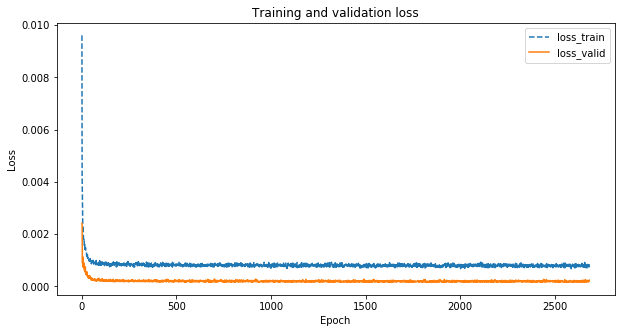

The last epoch: 2682
Finish training at epoch: 682


In [7]:
saved_model = tf.keras.models.load_model('st7_checkpoints/lstm_1d8.hdf5')

acc = model.history.history['accuracy']
loss = model.history.history['loss']
val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']
epochs = range(1, len(loss) + 1)

print('Min of Train Loss: {:.5f}'.format(np.min(loss)))
print('Min of Valid Loss: {:.5f}'.format(np.min(val_loss)))

plt.figure(num = 2, figsize = (10, 5))
plt.plot(epochs, loss, '--', label='loss_train')
plt.plot(epochs, val_loss, label='loss_valid')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('st7_checkpoints/lstm_1d8_history_loss.png')
plt.show()

print('The last epoch:', es.stopped_epoch+1 )
print('Finish training at epoch:', es.stopped_epoch+1-num_improvement)


(1307, 8, 7) (1307, 1)
[3030.] [3063.98585965]
Valid_MAE: 210.558 (m3/s)
Valid_RMSE: 313.780 (m3/s)
Valid_NSE: 0.9803


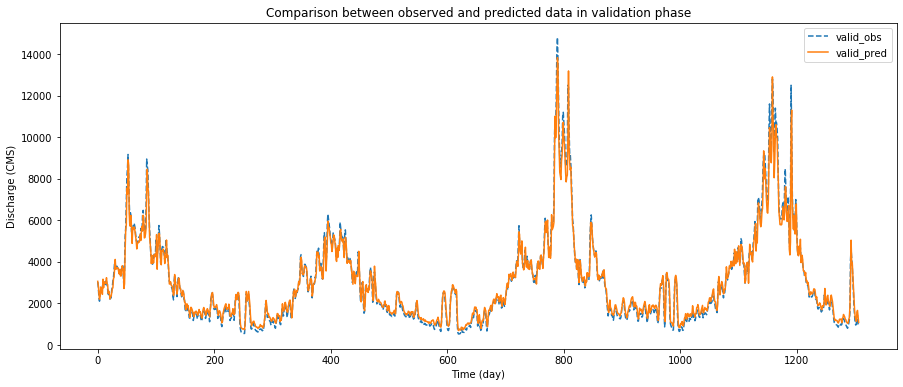

In [8]:
# Load the Validation dataset
valid_pred = model.predict(validX)
print(validX.shape, valid_pred.shape)

valid_concat = np.concatenate((valid_data[seq_length+(n-1) :, 0: (input_dim-1)], valid_pred), axis=1)
valid_invert = scaler.inverse_transform(valid_concat)

org_valid_pred = valid_invert[:, [-1]]                           
org_validY = data_valid[seq_length+(n-1) :, [-1]]

print(org_validY[0], org_valid_pred[0])                     

valid_NSE = r2_score(org_validY, org_valid_pred)
valid_MAE = mean_absolute_error(org_validY, org_valid_pred)
valid_RMSE = np.sqrt(mean_squared_error(org_validY, org_valid_pred))

print('Valid_MAE: {}'.format(np.around(valid_MAE, decimals = 3)), '(m3/s)')
print('Valid_RMSE: %.3f' % valid_RMSE, '(m3/s)')    # 2 ways to show
print('Valid_NSE: {}'.format(np.around(valid_NSE, decimals = 4)))

# Plot Validation data
plt.figure(num = 2, figsize = (15,6))
plt.plot(org_validY, '--', label = 'valid_obs')
plt.plot(org_valid_pred, label = 'valid_pred')
plt.title('Comparison between observed and predicted data in validation phase')
plt.legend()
plt.xlim()
plt.ylim()
plt.xlabel('Time (day)')
plt.ylabel('Discharge (CMS)')
plt.savefig('st7_checkpoints/lstm_1d8_valid_pred.png')
plt.show()
